# Dynamics of Boolean Networks

In this tutorial, we study the *dynamics* of Boolean networks.
Building on the construction and structural analysis from previous tutorials,
we now focus on characterizing the long-term behavior of Boolean networks.

You will learn how to:

- simulate Boolean network dynamics under different updating schemes,
- compute and classify attractors,
- analyze basins of attraction,
- relate network structure to dynamical behavior.

## Setup

In [1]:
import boolforge
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## State space of a Boolean network

A Boolean network with $N$ nodes defines a dynamical system on the discrete
state space $\{0,1\}^N$.

Each state is a binary vector

$$
\mathbf{x} = (x_0, \ldots, x_{N-1}) \in \{0,1\}^N,
$$

where $x_i$ denotes the state of node $i$.

We use a small Boolean network as a running example.

In [2]:
string = """
x = y
y = x OR z
z = y
"""

bn = boolforge.BooleanNetwork.from_string(string, separator="=")

print("Variables:", bn.variables)
print("N:", bn.N)
print("bn.I:", bn.I)
print("bn.F:", bn.F)

Variables: ['x' 'y' 'z']
N: 3
bn.I: [array([1]), array([0, 2]), array([1])]
bn.F: [BooleanFunction(f=[0, 1]), BooleanFunction(f=[0, 1, 1, 1]), BooleanFunction(f=[0, 1])]


All state vectors follow the variable order given by `bn.variables`.
For small networks, we can enumerate all $2^N$ states explicitly.

In [3]:
all_states = boolforge.get_left_side_of_truth_table(bn.N)
print(pd.DataFrame(all_states, columns=bn.variables).to_string())

   x  y  z
0  0  0  0
1  0  0  1
2  0  1  0
3  0  1  1
4  1  0  0
5  1  0  1
6  1  1  0
7  1  1  1


## Dynamics of synchronous Boolean networks

Under *synchronous updating*, all nodes are updated simultaneously, defining
a deterministic update map

$$
\mathbf{x}(t+1) = F(\mathbf{x}(t)).
$$

### Exact computation

In [4]:
for state in all_states:
    print(state, "-->", bn.update_network_synchronously(state))

[0 0 0] --> [0 0 0]
[0 0 1] --> [0 1 0]
[0 1 0] --> [1 0 1]
[0 1 1] --> [1 1 1]
[1 0 0] --> [0 1 0]
[1 0 1] --> [0 1 0]
[1 1 0] --> [1 1 1]
[1 1 1] --> [1 1 1]


This output matches the synchronous truth table representation:

In [5]:
print(bn.to_truth_table().to_string())

   x(t)  y(t)  z(t)  x(t+1)  y(t+1)  z(t+1)
0     0     0     0       0       0       0
1     0     0     1       0       1       0
2     0     1     0       1       0       1
3     0     1     1       1       1       1
4     1     0     0       0       1       0
5     1     0     1       0       1       0
6     1     1     0       1       1       1
7     1     1     1       1       1       1


Each state has exactly one successor, so the dynamics consist of transient
trajectories leading into *attractors* (steady states or cycles).

In this example, the network has:

- two steady states: $(0,0,0)$ and $(1,1,1)$,
- one cyclic attractor of length 2: $(0,1,0) \leftrightarrow (1,0,1)$.

### Exhaustive attractor computation

In [6]:
dict_dynamics = bn.get_attractors_synchronous_exact()

The returned dictionary contains:

- `STG`: the synchronous state transition graph,
- `NumberOfAttractors`,
- `Attractors`,
- `AttractorID`,
- `BasinSizes`.

For computational reasons, binary vectors are identified by their decimal representation.
The state transition graph can be decoded as follows:

In [7]:
for state in range(2 ** bn.N):
    next_state = dict_dynamics["STG"][state]
    print(
        state,
        "=",
        boolforge.dec2bin(state, bn.N),
        "-->",
        next_state,
        "=",
        boolforge.dec2bin(next_state, bn.N),
    )

0 = [0, 0, 0] --> 0 = [0, 0, 0]
1 = [0, 0, 1] --> 2 = [0, 1, 0]
2 = [0, 1, 0] --> 5 = [1, 0, 1]
3 = [0, 1, 1] --> 7 = [1, 1, 1]
4 = [1, 0, 0] --> 2 = [0, 1, 0]
5 = [1, 0, 1] --> 2 = [0, 1, 0]
6 = [1, 1, 0] --> 7 = [1, 1, 1]
7 = [1, 1, 1] --> 7 = [1, 1, 1]


After repeated updates, the system settles into periodic behavior. That is,
irrespective of the initial state, an attractor is reached. The list
of all attractors (in decimal representation) can be displayed. 

In [8]:
print(dict_dynamics['Attractors'])

[[0], [2, 5], [7]]


Attractors can be printed in binary representation:

In [9]:
for attractor in dict_dynamics["Attractors"]:
    print(f"Attractor of length {len(attractor)}:")
    for state in attractor:
        print(state, boolforge.dec2bin(state, bn.N))
    print()

Attractor of length 1:
0 [0, 0, 0]

Attractor of length 2:
2 [0, 1, 0]
5 [1, 0, 1]

Attractor of length 1:
7 [1, 1, 1]



The information which state transitions to which attractor is stored in a dictionary.
Here, the indices correspond to the list of attractors in `dict_dynamics['Attractors']`.

In [10]:
print(dict_dynamics['AttractorID'])

[0 1 1 2 1 1 2 2]


Finally, the basin size of each attractor is determined by the number of states that eventually transition to an attractor.
By definition, the sum of all basin sizes is always $2^N$. To simplify the comparison of
the basin size distribution for networks of different size, `BoolForge` normalizes the basin sizes by default.

In [11]:
print(dict_dynamics['BasinSizes'])

[0.125 0.5   0.375]


### Monte Carlo simulation

For larger networks, exhaustive enumeration is infeasible.
Monte Carlo simulation approximates the attractor landscape.

In [12]:
dict_dynamics = bn.get_attractors_synchronous(n_simulations=100)
print(dict_dynamics['Attractors'])
print(dict_dynamics['BasinSizes'])

[[7], [2, 5], [0]]
[45, 47, 8]


The simulation returns additional information:

- sampled initial states,
- the number of timeouts (trajectories not reaching an attractor before timeout).

In the absence of timeouts: If an attractor has relative basin size $q$, 
the probability that it is found from $m$ random initializations is $1 - (1-q)^m$.

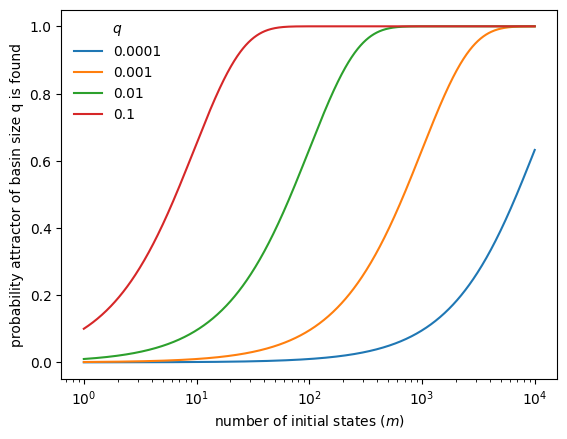

In [13]:
qs = [0.0001, 0.001, 0.01, 0.1]
ms = np.logspace(0, 4, 1000)

fig, ax = plt.subplots()
for q in qs:
    ax.semilogx(ms, 1 - (1 - q) ** ms, label=str(q))

ax.legend(title=r"$q$", frameon=False)
ax.set_xlabel("number of initial states ($m$)")
ax.set_ylabel("probability attractor of basin size q is found")
plt.show()

## Dynamics of asynchronous Boolean networks

Synchronous updating is computationally convenient but biologically unrealistic.
Asynchronous updating assumes that only one node is updated at a time.

### Steady states under general asynchronous update

BoolForge can compute steady states under general asynchronous updating.

In [14]:
dict_dynamics = bn.get_steady_states_asynchronous_exact()
print(dict_dynamics['SteadyStates'])
print(dict_dynamics['NumberOfSteadyStates'])

[0, 7]
2


This reveals the same two steady states as in the synchronous case.
However, the limit cycle does not exist under asynchronous update.
In addition, the full asynchronous transition graph and absorption
probabilities are returned.

In [15]:
print(dict_dynamics['STGAsynchronous'])
print(dict_dynamics['FinalTransitionProbabilities'])

{0: {0: 1.0}, 1: {1: 0.3333333333333333, 3: 0.3333333333333333, 0: 0.3333333333333333}, 2: {6: 0.3333333333333333, 0: 0.3333333333333333, 3: 0.3333333333333333}, 3: {7: 0.3333333333333333, 3: 0.6666666666666666}, 4: {0: 0.3333333333333333, 6: 0.3333333333333333, 4: 0.3333333333333333}, 5: {1: 0.3333333333333333, 7: 0.3333333333333333, 4: 0.3333333333333333}, 6: {6: 0.6666666666666666, 7: 0.3333333333333333}, 7: {7: 1.0}}
[[1.         0.        ]
 [0.5        0.5       ]
 [0.33333333 0.66666667]
 [0.         1.        ]
 [0.5        0.5       ]
 [0.33333333 0.66666667]
 [0.         1.        ]
 [0.         1.        ]]


The state transition graph describes for each state the possible next states that the system may
transition to, in addition to the transition probabilities. 
The absorption probabilities indicate that from many states multiple steady states may be reached.
The size of each basin of attraction is the (column-wise) average of these probabilities.

In [16]:
print(dict_dynamics['BasinSizes'])
print(dict_dynamics['BasinSizes'] == 
      np.mean(dict_dynamics['FinalTransitionProbabilities'],0))

[0.33333333 0.66666667]
[ True  True]


Note that `BoolForge` currently does not detect complex cyclic attractors under
asynchronous update; for this task, specialized tools such as
`pystablemotifs` are recommended.

### Monte Carlo approximation

As in synchronous case, `BoolForge` also contains a Monte Carlo routine
for sampling asynchronous dynamics.

The simulation provides:

- a lower bound on the number of steady states,
- approximate basin size distributions,
- samples of the asynchronous state transition graph.

In [17]:
dict_dynamics = bn.get_steady_states_asynchronous(n_simulations=500)
print(dict_dynamics['SteadyStates'])
print(dict_dynamics['NumberOfSteadyStates'])
print(dict_dynamics['BasinSizes'])

[7, 0]
2
[338, 162]


### Sampling from a fixed initial condition

In [18]:
dict_dynamics = bn.get_steady_states_asynchronous_given_one_initial_condition(
    initial_condition=[0, 0, 1], n_simulations=500
)
dict_dynamics

{'SteadyStates': [0, 7, 9, 4],
 'NumberOfSteadyStates': 4,
 'BasinSizes': [259, 163, 37, 41],
 'TransientTimes': [[1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,


## Summary and outlook

In this tutorial you learned how to:

- simulate Boolean network dynamics,
- compute synchronous attractors exactly and approximately,
- analyze basin sizes,
- compute steady states under asynchronous updating.

This concludes the function- and network-level analysis.
Subsequent work focuses on large-scale dynamical analysis,
perturbations, and stability in Boolean network models.